# Notebook to explore the metric data columns

## Load libraries and predefine some functions

In [16]:
# !pip install ome_zarr 
!pip install ome_zarr | grep -v 'already satisfied' #avoid warnings

In [17]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv
from upath import UPath as Path
from aicsimageio import AICSImage
from ome_zarr.reader import Reader
from ome_zarr.io import parse_url
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)


# Should these functions not be 

def read_ome_zarr(path, level=0, image_name="default"):
    path = str(path if image_name is None else Path(path) / image_name)
    reader = Reader(parse_url(path))

    node = next(iter(reader()))
    pps = node.metadata["coordinateTransformations"][0][0]["scale"][-3:]
   
    return AICSImage(
        node.data[level].compute(),
        channel_names=node.metadata["name"],
        physical_pixel_sizes=pps
    )

def rescale_image(img_data, channels):
    img_data = img_data.squeeze().astype(np.float32)
    
    for ix, channel in enumerate(channels):
        if "_seg" not in channel:
            img_data[ix] -= 1
            
            img_data[ix] = np.where(
                img_data[ix] >= 0,
                img_data[ix] / img_data.max(),
                -1
            )
    return img_data.astype(np.float16)

## Load the manifest and explore dimensions

In [18]:
cells_df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")
print(f'Number of cells: {len(cells_df)}')
print(f'Number of columns: {len(cells_df.columns)}')

Number of cells: 215081
Number of columns: 1242


### Download a CSV file with n=10 cells to explore in Excel

In [19]:
cells_df.sample(n=10).to_csv('snippet.csv') #then right click on the file to download

## Make a couple of plots of metrics across 

### Make a bar plot of the number of cells per structure, stratified based on Microscope Pipeline ID

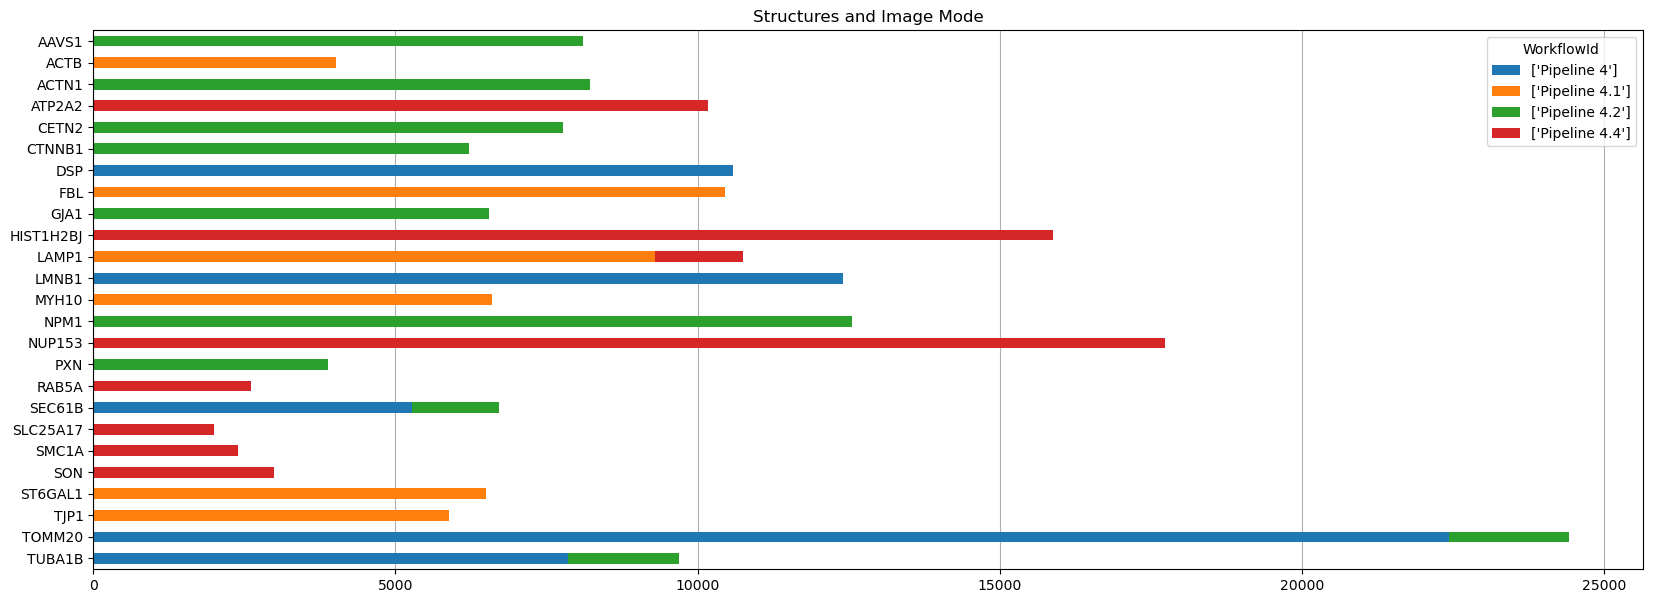

In [20]:
table = pd.pivot_table(cells_df, index="structure_name", columns="WorkflowId", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Image Mode")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

### Histogram for cell volume/height

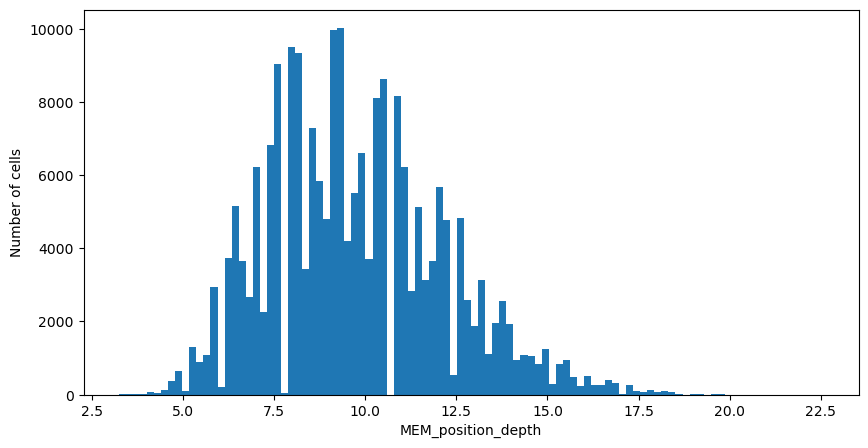

In [21]:
# select the metric (WE NEED MORE CLEAR LABELS THAN MEM_position_depth)
metric = "MEM_position_depth"
# convert pixels to micrometers (CONSIDER UPDATING DATASET TO USE MICROMETERS)
pix_size = 0.108
scl = pix_size**1
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
axes.hist(cells_df[metric] * scl, bins=100)
axes.set_xlabel(metric)
axes.set_ylabel("Number of cells")
plt.show()

### Make a violin plot of cell height across a given stratifier

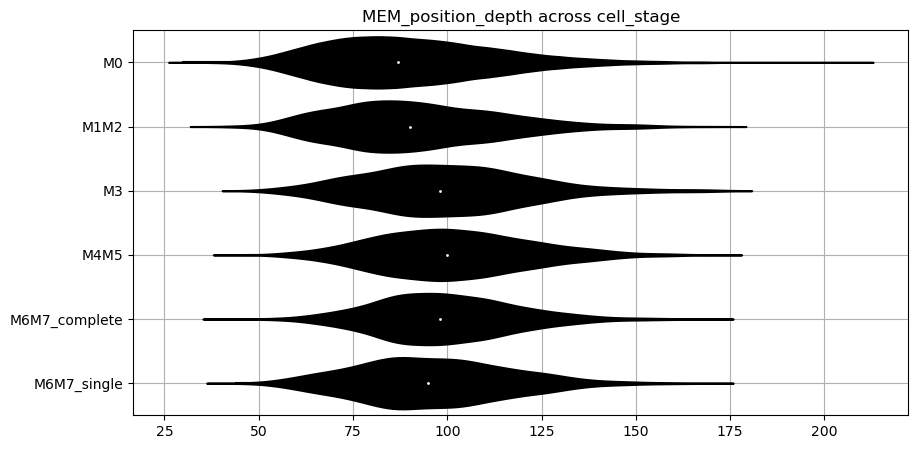

In [22]:
# select the metric (WE NEED MORE CLEAR LABELS THAN MEM_position_depth)
metric = "MEM_position_depth"
stratifier = "cell_stage"
order = np.sort(cells_df[stratifier].unique())
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(
    y=stratifier,
    x=metric,
    order = order,
    color="black",
    data=cells_df,
    scale="width",
    ax=axes
)

axes.set_title(f"{metric} across {stratifier}")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.set_ylabel(None)
axes.set_xlabel(None)

plt.show()

## Select a subset of cells (1,000 cells per mitotic stage) and plot some metrics for this subset

## Make a simple data of edge vs. non-edge cells



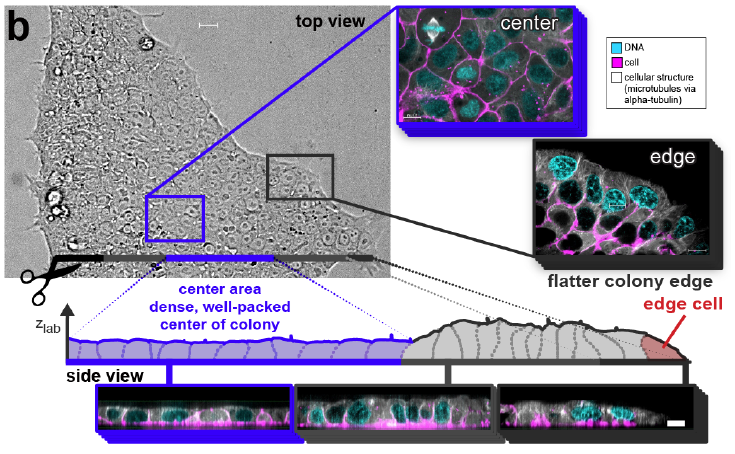 

Top and side views (single slice) of hiPSCs with FP-tagged microtubules (via alpha-tubulin), grown in tightly packed, epithelial-like colonies and labeled with cell membrane (magenta) and DNA (cyan) dyes to permit imaging and segmenting of cells and nuclei. Cells were most frequently imaged halfway towards the centers of large, well-packed colonies (blue) where they behave most consistently, but were also imaged at other locations within the colony, such as at the edges of colonies (red).

In [61]:
n = 2500 #number of cells per class
# Sample cells for each class
edge_label = cells_df["edge_flag"].unique()
# print(np.count_nonzero([cells_df["edge_flag"] == 1]), np.count_nonzero([cells_df["edge_flag"] == 0]))
index = pd.Series([])
for s, struct in enumerate(edge_label):
    index = index.append(
        cells_df[cells_df["edge_flag"] == s]
        .sample(n=n)
        .index.to_series()
    )
cells_edgeVSnoedge = cells_df.loc[index]
print(f'Number of cells: {len(cells_edgeVSnoedge)}')
print(f'Number of columns: {len(cells_edgeVSnoedge.columns)}')



/tmp/ipykernel_406/3804606038.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  index = pd.Series([])


Number of cells: 5000
Number of columns: 1242


/tmp/ipykernel_406/3804606038.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  index = index.append(
/tmp/ipykernel_406/3804606038.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  index = index.append(


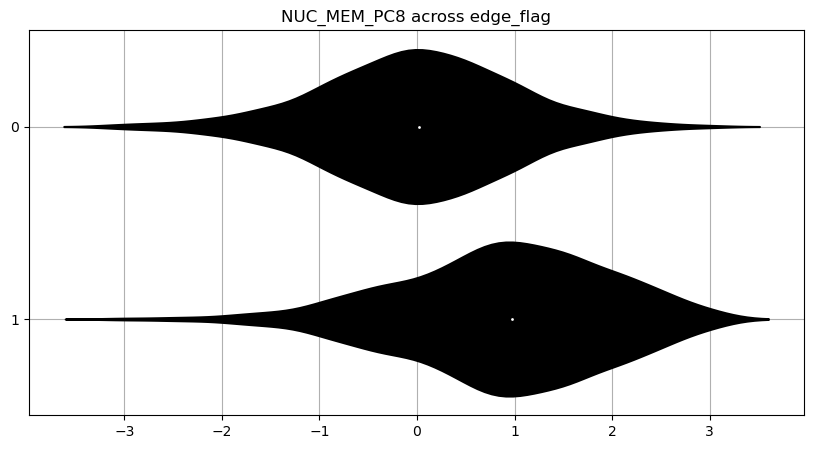

In [70]:
# select the metric (WE NEED MORE CLEAR LABELS THAN MEM_position_depth)
cells_edgeVSnoedge['edge_flag'] = cells_edgeVSnoedge.edge_flag.astype('category')
metric = "NUC_MEM_PC8"
stratifier = "edge_flag"
order = np.sort(cells_edgeVSnoedge[stratifier].unique())
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(
    y=stratifier,
    x=metric,
    order = order,
    color="black",
    data=cells_edgeVSnoedge,
    scale="width",
    ax=axes
)

axes.set_title(f"{metric} across {stratifier}")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.set_ylabel(None)
axes.set_xlabel(None)

plt.show()

## Do some statistical tests to see which feature shows the strongest difference between edge and non-edge cells

In [71]:
# import t-test and Kolmogorov-Smirnov test
from scipy.stats import ttest_ind,kstest

# select features to test
selected_features = ['NUC_shape_volume','NUC_position_depth','NUC_roundness_surface_area','MEM_shape_volume','MEM_position_depth','MEM_roundness_surface_area',\
                     'NUC_MEM_PC1','NUC_MEM_PC2','NUC_MEM_PC3','NUC_MEM_PC4','NUC_MEM_PC5','NUC_MEM_PC6','NUC_MEM_PC7','NUC_MEM_PC8']

# create groups
edge_cells = cells_edgeVSnoedge[cells_edgeVSnoedge['edge_flag']==1]
noedge_cells = cells_edgeVSnoedge[cells_edgeVSnoedge['edge_flag']==0]

# do t-test
t_scores = np.empty([len(selected_features),1])
t_pvalues = np.empty([len(selected_features),1])
for i,feature in enumerate(selected_features):
    t_scores[i],t_pvalues[i] = ttest_ind(edge_cells[feature].dropna(), noedge_cells[feature].dropna())
    
# print(t_scores)

# do ks-test
ks_scores = np.empty([len(selected_features),1])
ks_pvalues = np.empty([len(selected_features),1])
for i,feature in enumerate(selected_features):
    ks_scores[i],ks_pvalues[i] = kstest(edge_cells[feature].dropna(), noedge_cells[feature].dropna())
    
# print(ks_scores)



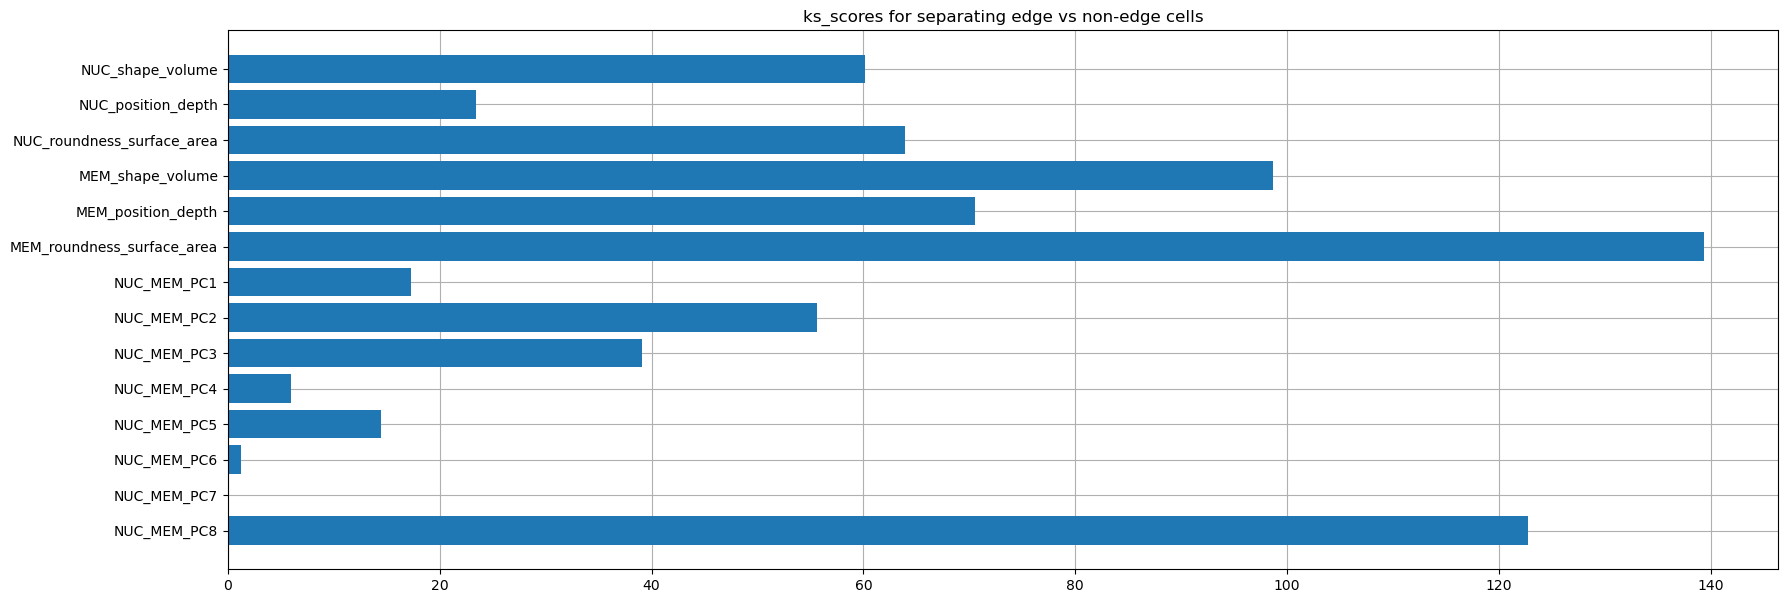

In [78]:
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
# plt.barh(y = selected_features, width = abs(ks_scores.squeeze()))
plt.barh(y = selected_features, width = -np.log10(ks_pvalues.squeeze()))
axes.set_ylabel(None)
axes.set_title("ks_scores for separating edge vs non-edge cells")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

## Build simple classifier (Random Forest out of the box) to discriminate 



In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(max_depth=2, random_state=0)
Xy = cells_edgeVSnoedge[[*selected_features, 'edge_flag']].dropna(axis=0).to_numpy()
X = Xy[:,0:-1]
y = Xy[:,-1]
# print(Xy.shape,X.shape,y.shape)
clf.fit(X, y)
y_pred = clf.predict(X)                                                                  
confusion_matrix(y, y_pred)                                                               



array([[1577,  473],
       [ 551, 1185]])

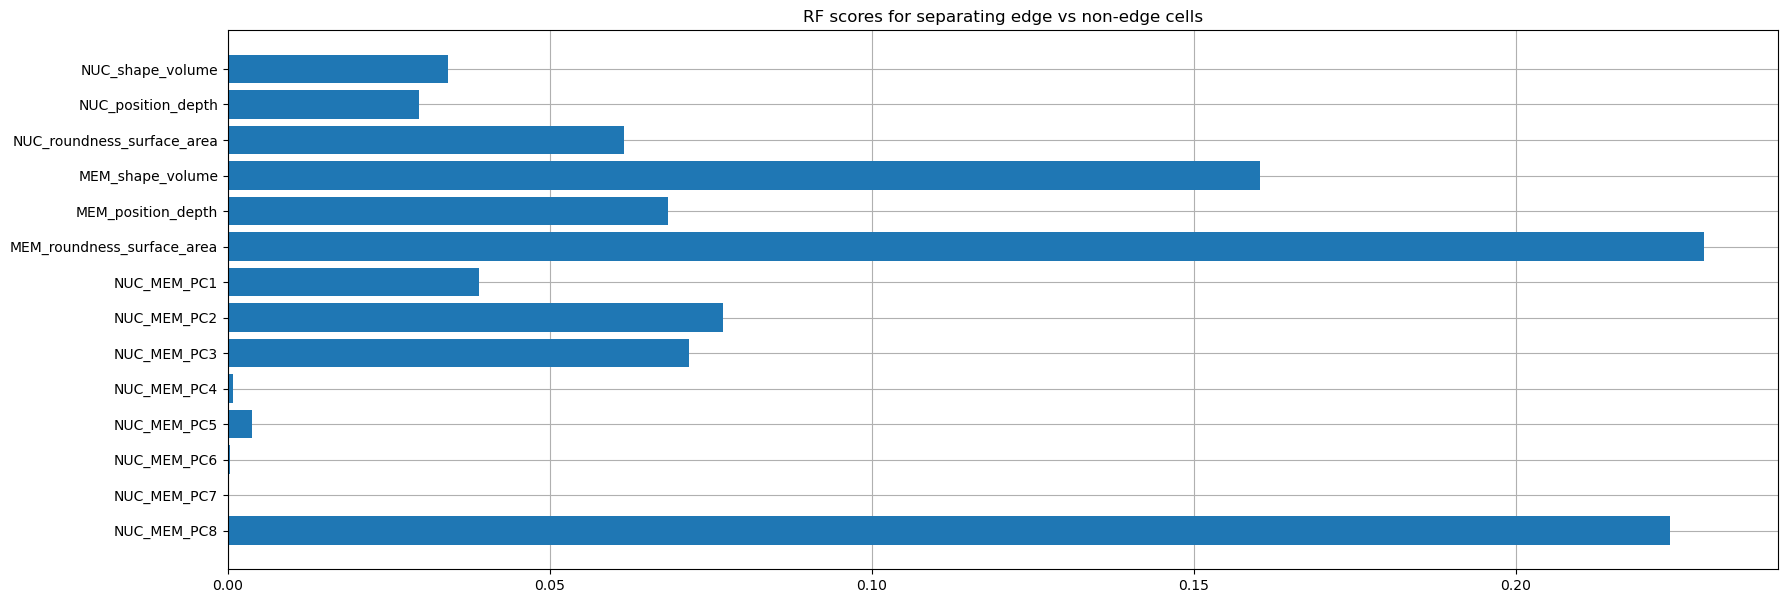

In [80]:
importances = clf.feature_importances_
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
plt.barh(y = selected_features, width = importances.squeeze())
axes.set_ylabel(None)
axes.set_title("RF scores for separating edge vs non-edge cells")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()